In [70]:
# Removing warnings
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [71]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Data Import</h2>

In [73]:
inventory_df = pd.read_json('./data/exported_listings.json')
stock_df = pd.read_json('./data/stock_listing_v2_1.json')
inventory_df = inventory_df.merge(stock_df, on='_id')

inventory_df

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,vendor_name,vendor_contact,expiration_date,storageLocation
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-01,Available,2628329,22,5,Coleman-Bailey Medical Supplies,+63 906 473 8909,NaN,ICU Equipment Room
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-02,Available,3140148,22,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-03,Available,2900449,18,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-04,Available,3160811,8,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-05,Available,2502553,21,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,149,1881,299,Wang-Foster Medical Supplies,+63 922 748 0407,1.892938e+12,Medical Supply Room
18644,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-28,Available,87,606,296,Coleman-Bailey Medical Supplies,+63 906 473 8909,1.893024e+12,Medical Supply Room
18645,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-29,Available,64,1100,178,Wu-Flores Medical Supplies,+63 973 346 5410,1.893110e+12,Medical Supply Room
18646,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-30,Available,91,571,148,Coleman-Bailey Medical Supplies,+63 906 473 8909,1.893197e+12,Medical Supply Room


In [74]:
patient_df = pd.read_csv('./data/patient_data_v2.csv')
patient_df

,diagnosis_id,date,primary_diagnosis,procedure_performed,item_used,item_type
0,1,2022-09-08,Pneumonia,Chest X-Ray,Surgical Mask,Consumable
1,1,2022-10-23,Pneumonia,Chest X-Ray,Gloves,Consumable
2,1,2022-07-06,Pneumonia,Chest X-Ray,Gown,Consumable
3,1,2022-04-11,Pneumonia,Chest X-Ray,Face Shield,Consumable
4,1,2023-11-08,Pneumonia,Chest X-Ray,X-Ray Machine,Equipment
...,...,...,...,...,...,...
33209,2692,2023-08-29,COVID-19,Chest X-Ray,Surgical Mask,Consumable
33210,2692,2024-02-16,COVID-19,Chest X-Ray,Gloves,Consumable
33211,2692,2024-03-26,COVID-19,Chest X-Ray,Gown,Consumable
33212,2692,2023-04-21,COVID-19,Chest X-Ray,Face Shield,Consumable


<h2 style='font-size: 2.5rem; font-weight: bold; text-align: center; padding: 1rem 0'>Exploratory Data Analysis (EDA)</h2>

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Univariate Analysis</h2>

<div style="width: 20%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Inventory Data</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [78]:
inventory_df.head(10)

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,vendor_name,vendor_contact,expiration_date,storageLocation
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-01,Available,2628329,22,5,Coleman-Bailey Medical Supplies,+63 906 473 8909,NaN,ICU Equipment Room
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-02,Available,3140148,22,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-03,Available,2900449,18,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-04,Available,3160811,8,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-05,Available,2502553,21,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
5,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-06,Available,3009553,10,4,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
6,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-07,Available,3144247,19,3,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
7,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-08,Available,2422728,7,5,Miles Inc Medical Supplies,+63 951 553 0757,NaN,ICU Equipment Room
8,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-09,Available,2347192,18,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
9,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-10,Available,2081183,22,3,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room


<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Bivariate Analysis</h2>

### Consumable - Mean Usage Per Day

In [89]:
consumable_avg_usage = inventory_df[inventory_df['category'] == 'Consumable'].groupby(inventory_df['title'])[['avg_usage_per_day']].mean()
consumable_avg_usage = consumable_avg_usage.reset_index().sort_values(by='avg_usage_per_day', ascending=False)
consumable_avg_usage

,title,avg_usage_per_day
8,Surgical Mask,1768.195146
9,Syringe,1111.834297
1,Bandages,909.330791
5,Gloves,601.610087
4,Face Shield,452.088608
0,Antiseptic Solution,302.795918
6,Gown,301.953422
3,Cotton Rolls,174.593237
7,IV Drip,124.933010
2,Blood Bags,84.977077


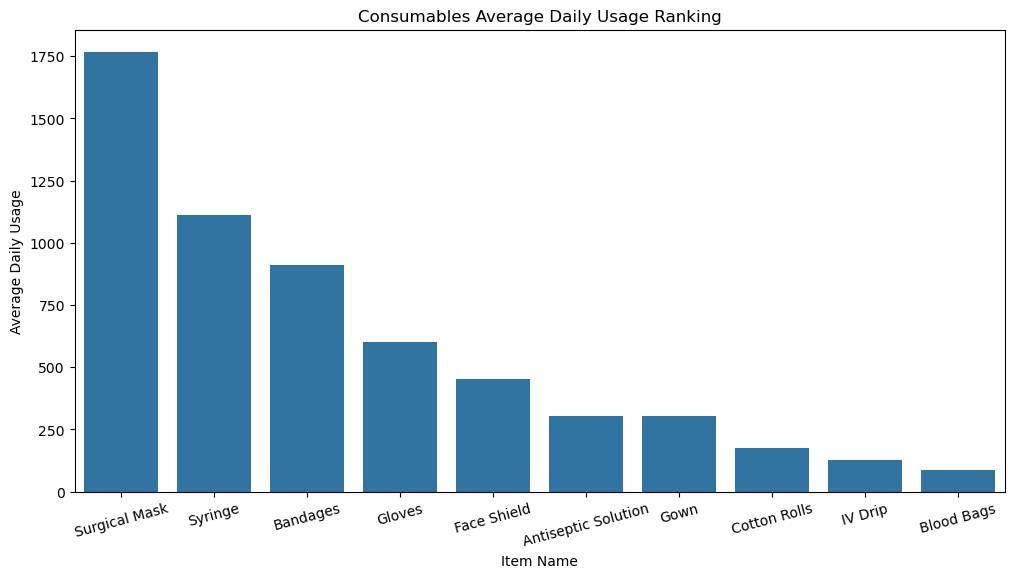

In [90]:
plt.figure(figsize=(12, 6))
sns.barplot(consumable_avg_usage, x='title', y='avg_usage_per_day')

plt.title('Consumables Average Daily Usage Ranking')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
plt.xticks(rotation=15)
plt.show()

### Equipment - Mean Usage Per Day

In [92]:
equipment_avg_usage = inventory_df[inventory_df['category'] == 'Equipment'].groupby(inventory_df['title'])[['avg_usage_per_day']].mean()
equipment_avg_usage = equipment_avg_usage.reset_index().sort_values(by='avg_usage_per_day', ascending=False)
equipment_avg_usage

,title,avg_usage_per_day
3,Infusion Pump,9.910405
5,Ventilator,2.974609
6,Wheelchair,2.521318
1,ECG Machine,1.512573
2,Hospital Bed,1.500000
4,MRI Scanner,0.533463
0,Defibrilator,0.516811
7,X-Ray-Machine,0.492424


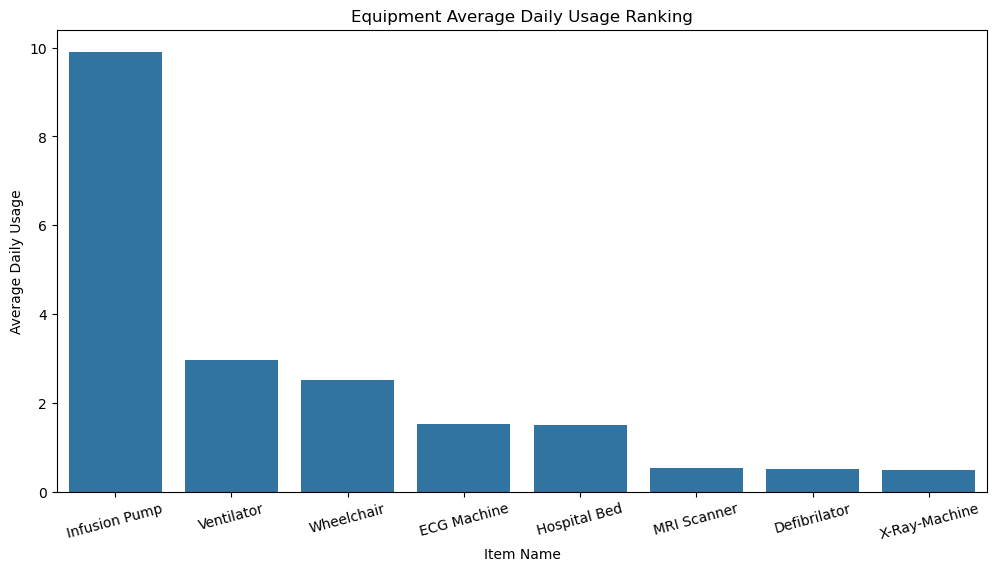

In [93]:
plt.figure(figsize=(12, 6))
sns.barplot(equipment_avg_usage, x='title', y='avg_usage_per_day')

plt.title('Equipment Average Daily Usage Ranking')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
plt.xticks(rotation=15)
plt.show()

### Consumable vs Equipment - Mean Usage Per Day

In [95]:
item_top_usage = pd.concat([consumable_avg_usage.iloc[[0]], equipment_avg_usage.iloc[[0]]])
item_top_usage

,title,avg_usage_per_day
8,Surgical Mask,1768.195146
3,Infusion Pump,9.910405


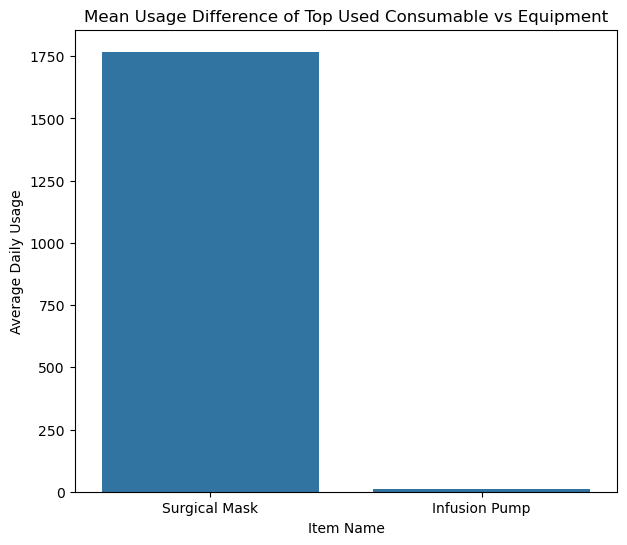

In [96]:
plt.figure(figsize=(7, 6))
plt.title('Mean Usage Difference of Top Used Consumable vs Equipment')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
sns.barplot(item_top_usage, x='title', y='avg_usage_per_day')
plt.show()

<h1 style='font-size: 2.5rem; text-align: center;'>Feature Engineering</h1>

In [98]:
inventory_df

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,vendor_name,vendor_contact,expiration_date,storageLocation
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-01,Available,2628329,22,5,Coleman-Bailey Medical Supplies,+63 906 473 8909,NaN,ICU Equipment Room
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-02,Available,3140148,22,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-03,Available,2900449,18,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-04,Available,3160811,8,1,Wu-Flores Medical Supplies,+63 973 346 5410,NaN,ICU Equipment Room
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-05,Available,2502553,21,1,Wang-Foster Medical Supplies,+63 922 748 0407,NaN,ICU Equipment Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,149,1881,299,Wang-Foster Medical Supplies,+63 922 748 0407,1.892938e+12,Medical Supply Room
18644,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-28,Available,87,606,296,Coleman-Bailey Medical Supplies,+63 906 473 8909,1.893024e+12,Medical Supply Room
18645,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-29,Available,64,1100,178,Wu-Flores Medical Supplies,+63 973 346 5410,1.893110e+12,Medical Supply Room
18646,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-30,Available,91,571,148,Coleman-Bailey Medical Supplies,+63 906 473 8909,1.893197e+12,Medical Supply Room


In [99]:
# Item Name, Date, Beginning Inventory, Ending Inventory, Monthly Usage
inventory_df1 = inventory_df.copy()
inventory_df1['date'] = pd.to_datetime(inventory_df1['date']) # Preprocessing: Datetime Conversion
inventory_df1['month'] = inventory_df1['date'].dt.to_period('M')
inventory_df1['year'] = inventory_df1['date'].dt.to_period('Y')

consumable_features = inventory_df1[inventory_df1['category'] == 'Consumable'].sort_values(['title', 'date']).groupby(['title', 'month']).agg(
        beginning_inventory = ('current_stock', 'first'),
        ending_inventory = ('current_stock', 'last'),
).reset_index()

consumable_features['category'] = 'Consumable'

equipment_features = inventory_df1[inventory_df1['category'] == 'Equipment'].sort_values(['title', 'date']).groupby(['title', 'year']).agg(
        beginning_inventory = ('current_stock', 'first'),
        ending_inventory = ('current_stock', 'last'),
).reset_index()

equipment_features['category'] = 'Equipment'

equipment_features = equipment_features.loc[equipment_features.index.repeat(12)].reset_index(drop=True)
equipment_features['month'] = pd.to_datetime(equipment_features['year'].astype(str) + '-' + np.tile(range(1, 13), len(equipment_features) // 12).astype(str)).dt.strftime('%Y-%m')
feature_df = pd.concat([consumable_features, equipment_features.drop(columns=['year'])])

# Annual Usage (For Equipment Turnover Rate)
annual_usage_df = inventory_df1.groupby(['title', 'year']).agg(annual_usage = ('avg_usage_per_day', 'sum')).reset_index()
feature_df['year'] = pd.to_datetime(feature_df['month'], format='%Y-%m')
feature_df['year'] = feature_df['year'].dt.to_period('Y')
feature_df = feature_df.merge(annual_usage_df, on=['title', 'year'], how='inner')

# Monthly Usage (For Consumable Turnover Rate) -> Shortcutting this by dividing annual usage by 12
feature_df['monthly_usage'] = feature_df['annual_usage'] / 12

'''

# To normalize in case the year is NOT YET COMPLETE (if year not complete = then the sum of the avg_usage is not really a year, but a few months only)
feature_df['annual_usage'] = feature_df.apply(lambda row: (row['annual_usage'] / row['months_available']) * 12, axis=1)

'''

# Unit Cost
cost_df = inventory_df.groupby('title')[['unit_cost']].mean().reset_index()
feature_df = feature_df.merge(cost_df, on='title', how='left')

# Annual Usage Value (AUG)
feature_df['annual_usage_value'] = feature_df['annual_usage'] * feature_df['unit_cost']

# Stock Turnover Rate
feature_df['stock_turnover_rate'] = np.where(feature_df['category'] == 'Consumable',
                                             feature_df['monthly_usage'] / ((feature_df['beginning_inventory'] + feature_df['ending_inventory']) / 2),
                                             feature_df['annual_usage'] / ((feature_df['beginning_inventory'] + feature_df['ending_inventory']) / 2),
                                            )

# Stock Variability
feature_df['stock_variability'] = inventory_df1.groupby('title')['current_stock'].transform(lambda x: x.std() / x.mean() if x.mean() != 0 else 0)

# Styling: Rerranging columns only
feature_df = feature_df[[
    'title', 'year', 'month', 'category', 'unit_cost', 'beginning_inventory', 'ending_inventory', 'annual_usage_value',
    'monthly_usage', 'annual_usage', 'stock_turnover_rate', 'stock_variability'
]]

feature_df

,title,year,month,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability
0,Antiseptic Solution,2022,2022-01,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353
1,Antiseptic Solution,2022,2022-02,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353
2,Antiseptic Solution,2022,2022-03,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353
3,Antiseptic Solution,2022,2022-04,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353
4,Antiseptic Solution,2022,2022-05,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353
...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024,2024-08,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353
644,X-Ray-Machine,2024,2024-09,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353
645,X-Ray-Machine,2024,2024-10,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353
646,X-Ray-Machine,2024,2024-11,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353


<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Feature Importance</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [ ]:
feature_df[['title', 'category', 'year', 'annual_usage_value', 'stock_turnover_rate']].drop_duplicates(subset=['title', 'category', 'year']).sort_values(by='stock_turnover_rate')

,title,category,year,annual_usage_value,stock_turnover_rate
72,Blood Bags,Consumable,2022,2.898883e+07,2.039973
252,IV Drip,Consumable,2022,9.805139e+06,2.126723
264,IV Drip,Consumable,2023,9.581384e+06,2.266253
276,IV Drip,Consumable,2024,1.023584e+07,2.654310
96,Blood Bags,Consumable,2024,2.817490e+07,2.849624
132,Cotton Rolls,Consumable,2024,6.010519e+06,3.043119
84,Blood Bags,Consumable,2023,2.763260e+07,3.493974
300,Surgical Mask,Consumable,2023,3.376805e+06,3.807405
180,Gloves,Consumable,2022,2.007247e+06,3.995318
24,Antiseptic Solution,Consumable,2024,4.700792e+07,4.143224


<div style="width: 30%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Feature Selection</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [103]:
#X_features = ['category', 'annual_usage_value', 'stock_turnover_rate', 'unit_cost', 'monthly_usage', 'annual_usage', 'stock_variability']
#X_features = ['annual_usage_value', 'unit_cost', 'monthly_usage', 'annual_usage', 'stock_turnover_rate', 'stock_variability']
#X_features = ['category', 'annual_usage_value', 'stock_turnover_rate', 'unit_cost', 'stock_variability']
#X_features = ['category', 'annual_usage_value', 'stock_turnover_rate', 'stock_variability']
X_features = ['category', 'annual_usage_value', 'stock_turnover_rate']
X = feature_df[X_features]
X

,category,annual_usage_value,stock_turnover_rate
0,Consumable,4.591761e+07,4.896173
1,Consumable,4.591761e+07,2.920345
2,Consumable,4.591761e+07,4.068684
3,Consumable,4.591761e+07,3.489133
4,Consumable,4.591761e+07,5.445129
...,...,...,...
643,Equipment,5.841180e+08,24.000000
644,Equipment,5.841180e+08,24.000000
645,Equipment,5.841180e+08,24.000000
646,Equipment,5.841180e+08,24.000000


<h1 style='font-size: 2.5rem; text-align: center;'>Clustering Model - ABC Analysis</h1>

In [ ]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=1))
])

pipeline.fit(X)
clusters = pipeline.predict(X)
feature_df1 = feature_df.copy()
feature_df1['cluster'] = clusters

# Rename clusters to A, B, C based on AUV values
cluster_mapping = {
    feature_df1.groupby('cluster')['annual_usage_value'].mean().idxmax(): 'A',
    feature_df1.groupby('cluster')['annual_usage_value'].mean().idxmin(): 'C'
}
cluster_mapping = {k: cluster_mapping.get(k, 'B') for k in range(3)}

# Map cluster labels to A, B, C
feature_df1['ABC_category'] = feature_df1['cluster'].map(cluster_mapping)
feature_df1

,title,year,month,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,cluster,ABC_category
0,Antiseptic Solution,2022,2022-01,Consumable,4.554325e+02,958,2474,4.591761e+07,8401.833333,100822,4.896173,0.504353,0,C
1,Antiseptic Solution,2022,2022-02,Consumable,4.554325e+02,2762,2992,4.591761e+07,8401.833333,100822,2.920345,0.504353,0,C
2,Antiseptic Solution,2022,2022-03,Consumable,4.554325e+02,2227,1903,4.591761e+07,8401.833333,100822,4.068684,0.504353,0,C
3,Antiseptic Solution,2022,2022-04,Consumable,4.554325e+02,2246,2570,4.591761e+07,8401.833333,100822,3.489133,0.504353,0,C
4,Antiseptic Solution,2022,2022-05,Consumable,4.554325e+02,2524,562,4.591761e+07,8401.833333,100822,5.445129,0.504353,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,X-Ray-Machine,2024,2024-08,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
644,X-Ray-Machine,2024,2024-09,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
645,X-Ray-Machine,2024,2024-10,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B
646,X-Ray-Machine,2024,2024-11,Equipment,3.744346e+06,5,8,5.841180e+08,13.000000,156,24.000000,0.504353,2,B


# Model Evaluation

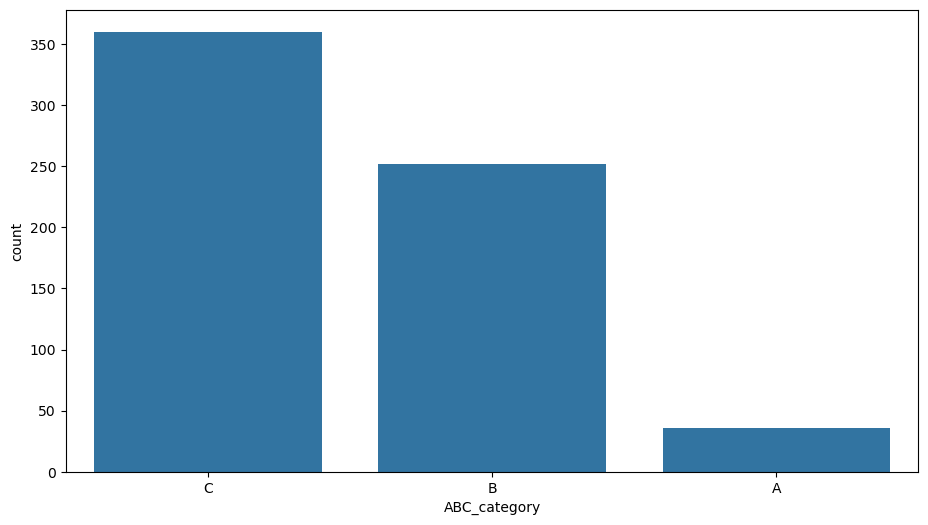

In [107]:
plt.figure(figsize=(11, 6))
sns.countplot(feature_df1, x='ABC_category')
plt.show()

In [108]:
feature_df1.groupby('ABC_category')[['title']].count().reset_index()

,ABC_category,title
0,A,36
1,B,252
2,C,360


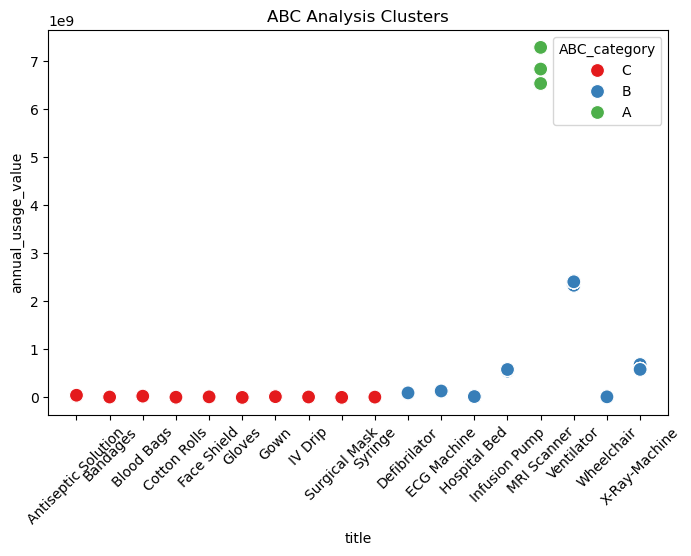

In [109]:
plt.figure(figsize=(8, 5))
sns.scatterplot(feature_df1, x='title', y='annual_usage_value', hue='ABC_category', palette='Set1', s=100)
plt.title('ABC Analysis Clusters')
plt.xticks(rotation=45)
plt.show()

# Model Export

In [111]:
abc_clusters_csv = './data/abc_clusters.csv'

if not os.path.exists(abc_clusters_csv):
    feature_df1.to_csv(abc_clusters_csv, index=False)

In [112]:
# Export model file
joblib.dump(pipeline, './models/hospital_abc_clf.joblib')

['./models/hospital_abc_clf.joblib']